# L3d: The Quicksort Algorithm
In this lab, we compare the average runtime of a recursive [Quicksort](https://en.wikipedia.org/wiki/Quicksort) implementation to a [Bubblesort implementation](https://en.wikipedia.org/wiki/Bubble_sort) and [Julia's built-in sort function](https://docs.julialang.org/en/v1/base/sort/#Base.sort) using [the BenchmarkTools.jl package](https://github.com/JuliaCI/BenchmarkTools.jl). 

We'll complete three main tasks in this notebook:
- **Task 1**: In this task, you will implement the Bubblesort algorithm, test your implementation for correctness, and benchmark its performance across different array sizes to establish a baseline to compare other algorithms against.
- **Task 2**: In the second task, we'll test an existing Quicksort implementation for correctness and benchmark its performance to compare against Bubblesort.
- **Task 3**: Finally, we'll benchmark Julia's built-in sort function to see how our custom implementations compare against an optimized library solution.

### Algorithms
Bubblesort is a simple method of ordering a list. 

> __How does Bubblesort work?__ It involves repeatedly passing through the list, comparing adjacent items, and swapping any two neighboring items that are out of order. The algorithm gets its name because smaller elements "bubble" to the top of the list, just like how air bubbles rise to the surface of water.
> 
> Let's take a look at the Bubblesort algorithm in more detail [here](CHEME-5800-L3d-Algorithm-Bubblesort-Fall-2025.ipynb).


Quicksort takes a different approach to sorting. 

> __How does Quicksort work?__ Quicksort is a recursive sorting algorithm that works by selecting a pivot element and partitioning the remaining elements into two sub-arrays based on their value relative to the pivot. The algorithm then recursively sorts the sub-arrays until they have fewer than two elements. The choice of pivot is critical for the algorithm's efficiency.
> 
> Let's take a look at the Quicksort algorithm [here](CHEME-5800-L3d-Algorithm-Quicksort-Fall-2025.ipynb).

We are going to see some surprising results! Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our environment:

In [3]:
include(joinpath(@__DIR__, "Include-student.jl")); # what is this doing?

    Updating git-repo `https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Glib_jll ───── v2.86.0+0
   Installed FillArrays ─── v1.14.0
   Installed PrettyTables ─ v3.0.8
   Installed DataFrames ─── v1.8.0
    Updating `~/Desktop/julia_work/CHEME-5800-Fall-2025/CHEME-5800-Labs-Fall-2025/labs/week-3/L3d/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.6.0
  [5ae59095] + Colors v0.13.1
  [a93c6f00] + DataFrames v1.8.0
  [864edb3b] + DataStructures v0.19.1
  [5789e2e9] + FileIO v1.17.0
  [033835bb] + JLD2 v0.6.2
  [682c06a0] + JSON v0.21.4
  [ec8451be] + KernelFunctions v0.10.65
  [91a5bcdd] + Plots v1.40.19
  [08abe8d2] + PrettyTables v3.0.8
  [10745b16] + Statistics v1.11.1
  [24b76065] + VLDataScienceMachineLearningPackage v0.1.0 `https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl.git#main`
  [37e2e46d] ~ LinearAlgebra ⇒ v1.11.0
  [9a3f8284] ~ Ra

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
Before we get started, let's set up some constants. See the comment next to each value for what it is, its permissible values, units, etc.

In [6]:
max_number_of_trials = 12; # exponent
number_of_items_per_trial = [2^i for i ∈ 1:max_number_of_trials]; # this is an array comprehension, yet another iteration pattern!

___

## Task 1: Establish a performance baseline: Bubblesort
In this task, we show that our bubblesort implementation works as expected. We also establish a performance baseline for comparison with the Quicksort algorithm.

> We'll use [the `Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) to write __unit tests__ for our bubble sort implementation. The [`Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) provides a framework for writing and running tests in Julia, including support for assertions, test cases, and test suites. Let's use [the @test macro](https://docs.julialang.org/en/v1/stdlib/Test/#Test.@test) to check that our bubble sort implementation works correctly.

So, did we pass the tests?

In [9]:
let

    # initialize -
    N = 1000; # number of elements in the random vector
    arr = rand(N); # random vector length N

    # check: do we get the same result as the built-in sort function?
    @test sort(arr) == bubblesort(arr) # if the test fails, an error is thrown!
end

Test Passed

Okay, so if we get here, all seems to be good with [our `bubblesort(...)` implementation](src/Compute.jl), so let's see how our code performs as we increase the size of the vector that we are sorting.

Now let's measure how [our `bubblesort(...)` function](src/Compute.jl) performs as we increase the size of the input array. We'll use the [BenchmarkTools.jl package](https://github.com/JuliaCI/BenchmarkTools.jl) to get accurate timing measurements.

The code below uses a [`let ... end` block](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Let-Blocks) to create a local scope and performs the following steps:
1. **Initialize a DataFrame** to store our results with columns for array size (`n`), mean runtime (`μ`), and standard deviation (`σ`) using the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl)
2. **Loop through different array sizes** from our `number_of_items_per_trial` array (powers of 2 from $2^{1}$ to $2^{12}$)
3. **For each array size:**
   - Create a benchmark using `@benchmarkable` that will test our `bubblesort` function
   - Use `setup=` to generate fresh random data for each trial (avoiding measuring data generation time)
   - Run the benchmark multiple times and collect timing statistics
   - Store the results (array size, mean time, standard deviation) as a row in our DataFrame

The result will be stored in the `bubble_sort_data::DataFrame` variable containing performance data that we can analyze and visualize.

In [12]:
bubble_sort_data = let
    bubble_sort_data = DataFrame();
    for i ∈ eachindex(number_of_items_per_trial)
        size_of_rand_vec_to_sort = number_of_items_per_trial[i];
    
        # run the test with different size vectors -
        test_run = @benchmarkable bubblesort(data) setup=(data=rand(0:number_of_items_per_trial[end], $(size_of_rand_vec_to_sort)));
        tune!(test_run)
        results = run(test_run)
    
        # store the results -
        row = (
            n = size_of_rand_vec_to_sort,
            μ = mean(results.times),
            σ = std(results.times)
        );
        push!(bubble_sort_data, row)
    end
    bubble_sort_data
end

Row,n,μ,σ
,Int64,Float64,Float64
1,2,71.8167,186.953
2,4,79.0725,176.662
3,8,99.8612,184.49
4,16,184.743,292.75
5,32,548.278,1307.1
6,64,2457.77,166.025
7,128,11285.0,511.899
8,256,46800.1,3353.76
9,512,1.57755e5,4585.84


## Task 2: Quicksort
In this task, we verify that our Quicksort implementation works as expected. We also establish the performance of this method in comparison with the Bubblesort algorithm.

> As before, we'll use [the `Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) to write a __unit test__ for [our `quicksort(...)` implementation](src/Compute.jl). The [`Test.jl` package](https://docs.julialang.org/en/v1/stdlib/Test/) provides a framework for writing and running tests in Julia, including support for assertions, test cases, and test suites. Let's use [the @test macro](https://docs.julialang.org/en/v1/stdlib/Test/#Test.@test) to check that [our `quicksort(...)` implementation](src/Compute.jl) works correctly.

Does it work?

In [14]:
let

    # initialize -
    N = 1000; # number of elements in the random vector
    arr = rand(N); # random vector length N

    # check: do we get the same result as the built-in sort function?
    @test sort(arr) == quicksort(arr) # if the test fails, an error is thrown!
end

Test Passed

Okay, so if we get here, all seems to be good with our `quicksort(...)` implementation, so let's see how our code performs as we increase the vector size to be sorted. 

Let's use the same benchmarking pattern as we did for the Bubblesort algorithm. The benchmarking results for the Quicksort algorithm will be stored in the `quick_sort_data::DataFrame` variable containing performance data that we can analyze and visualize.

In [16]:
quick_sort_data = let
    
    quick_sort_data = DataFrame();
    for i ∈ eachindex(number_of_items_per_trial)
        size_of_rand_vec_to_sort = number_of_items_per_trial[i];
    
        # run the test with different size vectors -
        test_run = @benchmarkable quicksort(data) setup=(data=rand(0:number_of_items_per_trial[end], $(size_of_rand_vec_to_sort)));
        tune!(test_run)
        results = run(test_run)
    
        # store the results -
        row = (
            n = size_of_rand_vec_to_sort,
            μ = mean(results.times),
            σ = std(results.times)
        );
        push!(quick_sort_data, row)
    end
    quick_sort_data
end

Row,n,μ,σ
,Int64,Float64,Float64
1,2,394.899,975.006
2,4,901.404,2051.73
3,8,1970.37,16035.8
4,16,4170.03,28039.0
5,32,9657.89,66877.9
6,64,19962.4,2.0422e5
7,128,40192.2,2.90089e5
8,256,78403.7,3.42338e5
9,512,157337.0,3.64953e5


## Task 3: What is the scaling of the Built-in sort function?
Julia provides [sophisticated multi-method sorting capability](https://docs.julialang.org/en/v1/base/sort/#Sorting-Functions). How do our implementations perform against what Julia can offer? 

> __Buy versus build:__ This is yet another example of the __buy versus build__ conundrum. Should we build our own implementation, or __buy__ someone else's? You should (almost) always __buy__, and benefit from the hard (optimized) work of others. But let's see if that is true in this case.

We'll use the same benchmarking approach as we did for the Bubblesort and Quicksort algorithms. The results will be stored in the `julia_sort_data::DataFrame` variable containing performance data that we can analyze and visualize.

In [18]:
julia_sort_data = let
    julia_sort_data = DataFrame();
    for i ∈ eachindex(number_of_items_per_trial)
        size_of_rand_vec_to_sort = number_of_items_per_trial[i];
    
        # run the test with different size vectors -
        test_run = @benchmarkable sort(data) setup=(data=rand(0:number_of_items_per_trial[end], $(size_of_rand_vec_to_sort)));
        tune!(test_run)
        results = run(test_run)
    
        # store the results -
        row = (
            n = size_of_rand_vec_to_sort,
            μ = mean(results.times),
            σ = std(results.times)
        );
        push!(julia_sort_data, row)
    end
    julia_sort_data
end

Row,n,μ,σ
,Int64,Float64,Float64
1,2,94.7767,249.84
2,4,100.024,271.115
3,8,108.275,259.823
4,16,138.048,299.244
5,32,235.791,360.41
6,64,537.805,1293.02
7,128,821.713,1714.16
8,256,1574.75,14625.8
9,512,2895.94,20894.8


## Visualize
`Unhide` the code below to see how we plotted the average runtime of each sorting method as a function of the length of the vector $n$.

> __Summary__: For very short sequences, our `bubblesort(...)` implementation is the winner! However, once the sequences become large, [Julia `sort(...)` implementations are the clear winners](https://docs.julialang.org/en/v1/base/sort/#Sorting-Functions). Something interesting here: our `quicksort(...)` implementation seems to have similar scaling behavior to [the built-in `sort(...)` method](https://docs.julialang.org/en/v1/base/sort/#Sorting-Functions).

These results show the power of constants! When we do scaling analysis, we ignore constants, but they are important in practice. For example, Quicksort and Julia's built-in sort function have similar scaling behavior, but the constants are different (the built-in sort implementation appears to have a smaller constant factor, meaning it is faster in practice).

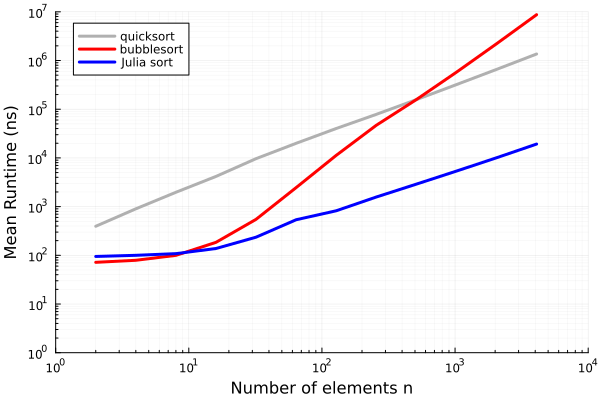

In [20]:
let
    plot(quick_sort_data[:,:n], quick_sort_data[:,:μ], label="quicksort", 
        yscale=:log10, xscale=:log10, lw=3, c=:gray69, minorgrid=true, legend=:topleft)
    plot!(bubble_sort_data[:,:n], bubble_sort_data[:,:μ], label="bubblesort", 
        yscale=:log10, xscale=:log10, lw=3, c=:red)
    plot!(julia_sort_data[:,:n], julia_sort_data[:,:μ], label="Julia sort", 
        yscale=:log10, xscale=:log10, lw=3, c=:blue)
    xlims!(1e+0, 1e+4)
    ylims!(1e+0, 1e+7)
    xlabel!("Number of elements n", fontsize=18)
    ylabel!("Mean Runtime (ns)", fontsize=18)
end

## Summary
So what did we learn from comparing these three sorting approaches? Surprisingly, our simple bubblesort actually wins for very small datasets, but it quickly becomes the slowest as the data grows due to its O(n²) complexity.

Our quicksort implementation shows much better scaling behavior, performing similarly to Julia's built-in sort in terms of growth rate. However, Julia's optimized sort function consistently outperforms our implementation with better constants and lower overhead.

The key takeaway? This is a perfect example of the "buy vs build" principle in programming. While implementing algorithms yourself is great for learning, production code should almost always use well-tested library functions that have been optimized by experts!